<a href="https://colab.research.google.com/github/KhondamirRustamov/AF-Multimer-cluster/blob/main/AF_Multimer_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title Installing ColabFold
%%time
!pip install -q biopython
!pip install -q MDAnalysis

import warnings
warnings.filterwarnings("ignore")
import json
import numpy as np
import matplotlib.pyplot as plt

import glob
from scipy.spatial import distance_matrix

import os
import sys
import urllib.request

import Bio
import Bio.PDB
import Bio.SeqRecord
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.decomposition import PCA

import pandas as pd

import MDAnalysis as mda
from MDAnalysis.analysis import pca, align, rms
#print('installing ColabFold...')
if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

!git clone https://github.com/HWaymentSteele/AF_Cluster
!pip install -r /content/AF_Cluster/requirements.txt
print('successful')

fatal: destination path 'AF_Cluster' already exists and is not an empty directory.
successful
CPU times: user 729 ms, sys: 120 ms, total: 849 ms
Wall time: 9.46 s


In [6]:
#@markdown **Input options and predict using full-MSA and ColabFold**

#@markdown Input ligand sequence first, metamorphic protein sequence second (in case of oligomers just input sequence twice)

from google.colab import files
sequence = 'MNAKVVVVLVLVLTALCLSDGKPVSLSYRCPCRFFESHVARANVKHLKILNTPNCALQIVARLKNNNRQVCIDPKLKWIQEYLEKALNKRFKM:MEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMTDKYRLHLSVADLLFVITLPFWAVDAVANWYFGNFLCKAVHVIYTVNLYSSVLILAFISLDRYLAIVHATNSQRPRKLLAEKVVYVGVWIPALLLTIPDFIFANVSEADDRYICDRFYPNDLWVVVFQFQHIMVGLILPGIVILSCYCIIISKLSHSKGHQKRKALKTTVILILAFFACWLPYYIGISIDSFILLEIIKQGCEFENTVHKWISITEALAFFHCCLNPILYAFLGAKFKTSAQHALTSVSRGSSLKILSKGKRGGHSSVSTESESSSFHSS' #@param {type:"string"}
name = 'test' #@param {type:"string"}
os.system(f'mkdir {name}/')
file_fasta = open(f'{name}/complex.fasta', 'w')
file_fasta.write(f'>{name}\n{sequence}\n')
file_fasta.close()
file_fasta = open(f'{name}/metamorphic.fasta', 'w')
file_fasta.write(f">{name}\n{sequence.split(':')[1]}\n")
file_fasta.close()
num_models = 5 #@param ["1", "2", "3", "4", "5"] {type:"raw"}

template_mode='None'
jobname=name
query_sequence = sequence

jobname_metamorphic = name+'_metamorphic'
metamorphic_sequence = sequence.split(':')[1]
# check if directory with jobname exists

# make directory to save results
os.makedirs(jobname, exist_ok=True)
os.makedirs(jobname_metamorphic, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
metamorphic_queries_path = os.path.join(jobname_metamorphic, f"{jobname_metamorphic}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

with open(metamorphic_queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname_metamorphic},{metamorphic_sequence}")

custom_template_path = None
use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
a3m_file = os.path.join(jobname,f"{jobname}.a3m")
a3m_file_metamorphic = os.path.join(jobname_metamorphic,f"{jobname_metamorphic}.a3m")

jobname test
sequence MNAKVVVVLVLVLTALCLSDGKPVSLSYRCPCRFFESHVARANVKHLKILNTPNCALQIVARLKNNNRQVCIDPKLKWIQEYLEKALNKRFKM:MEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMTDKYRLHLSVADLLFVITLPFWAVDAVANWYFGNFLCKAVHVIYTVNLYSSVLILAFISLDRYLAIVHATNSQRPRKLLAEKVVYVGVWIPALLLTIPDFIFANVSEADDRYICDRFYPNDLWVVVFQFQHIMVGLILPGIVILSCYCIIISKLSHSKGHQKRKALKTTVILILAFFACWLPYYIGISIDSFILLEIIKQGCEFENTVHKWISITEALAFFHCCLNPILYAFLGAKFKTSAQHALTSVSRGSSLKILSKGKRGGHSSVSTESESSSFHSS
length 445


2024-11-04 07:00:29,117 Running on GPU
2024-11-04 07:00:29,471 Found 5 citations for tools or databases
2024-11-04 07:00:29,472 Query 1/1: test (length 445)


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:20 remaining: 00:00]


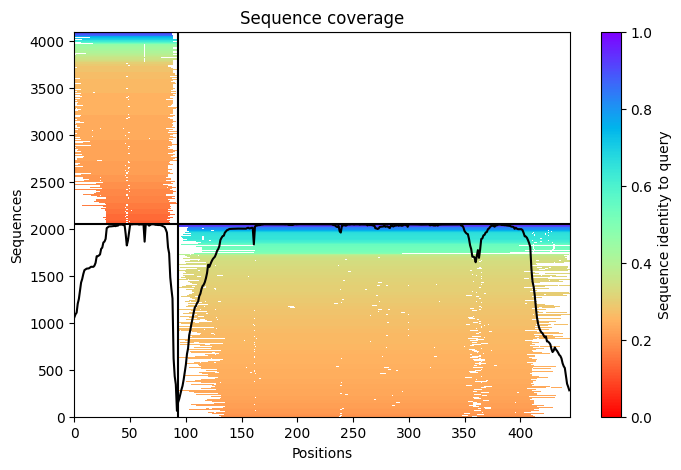

2024-11-04 07:00:52,685 Setting max_seq=508, max_extra_seq=2048
2024-11-04 07:02:26,830 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=66.7 pTM=0.646 ipTM=0.303
2024-11-04 07:03:14,814 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=75.7 pTM=0.741 ipTM=0.648 tol=4.89
2024-11-04 07:04:02,619 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=75.5 pTM=0.728 ipTM=0.653 tol=1.34
2024-11-04 07:04:50,422 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=76.4 pTM=0.737 ipTM=0.664 tol=0.314
2024-11-04 07:04:50,436 alphafold2_multimer_v3_model_1_seed_000 took 230.2s (3 recycles)


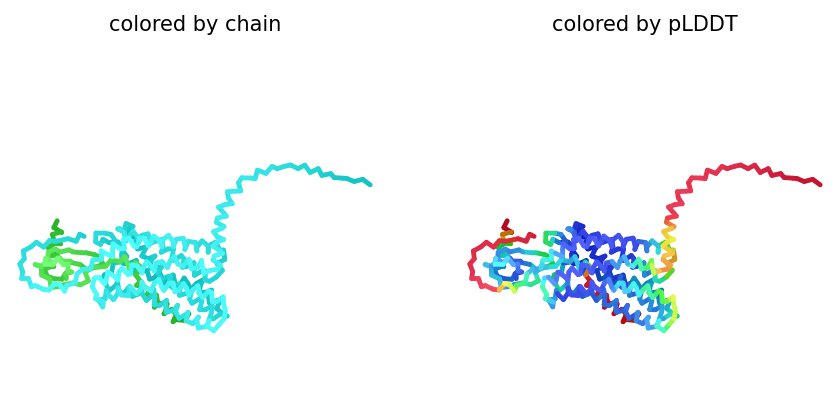

2024-11-04 07:04:51,324 reranking models by 'multimer' metric
2024-11-04 07:04:51,325 rank_001_alphafold2_multimer_v3_model_1_seed_000 pLDDT=76.4 pTM=0.737 ipTM=0.664
2024-11-04 07:04:52,345 Done


2024-11-04 07:05:32,528 Running on GPU
2024-11-04 07:05:32,534 Found 5 citations for tools or databases
2024-11-04 07:05:32,535 Query 1/1: test_metamorphic (length 352)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:13 remaining: 00:00]


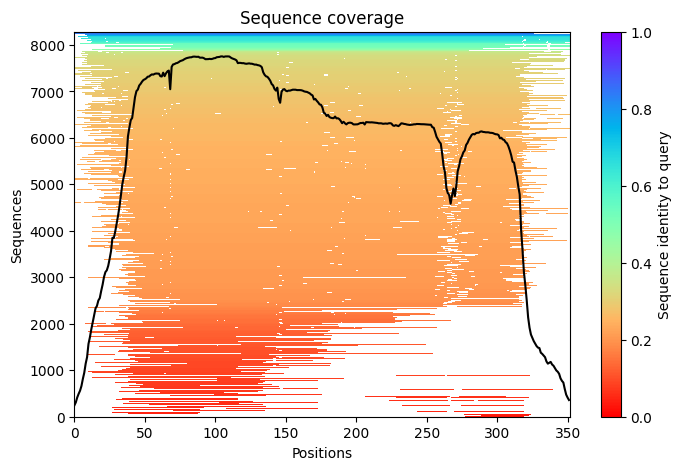

2024-11-04 07:05:48,683 Setting max_seq=512, max_extra_seq=5120
2024-11-04 07:07:05,451 alphafold2_model_1_seed_000 recycle=0 pLDDT=79.6
2024-11-04 07:07:38,713 alphafold2_model_1_seed_000 recycle=1 pLDDT=80.2 tol=3.15
2024-11-04 07:08:12,035 alphafold2_model_1_seed_000 recycle=2 pLDDT=80.7 tol=0.898
2024-11-04 07:08:45,483 alphafold2_model_1_seed_000 recycle=3 pLDDT=80.8 tol=0.662
2024-11-04 07:08:45,484 alphafold2_model_1_seed_000 took 162.1s (3 recycles)


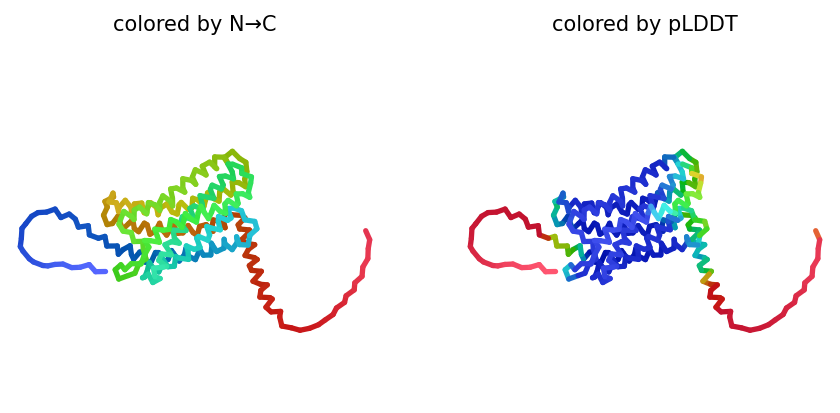

2024-11-04 07:08:45,897 reranking models by 'plddt' metric
2024-11-04 07:08:45,899 rank_001_alphafold2_model_1_seed_000 pLDDT=80.8
2024-11-04 07:08:46,519 Done


In [9]:
#@markdown **Predict structures using full-MSA and ColabFold**

#@markdown This might take up to 4-10 minutes, depending on the length of proteins (this step takes both downloading ColabFold params and making the prediction)

display_images = True
model_type = "auto"
num_recycles = "3"

pairing_strategy = "greedy"

max_msa = "auto"
num_seeds = 1
use_dropout = False

if max_msa == "auto": max_msa = None
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)

download_alphafold_params('alphafold2_multimer_v3', Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    msa_mode=msa_mode,
    model_type='alphafold2_multimer_v3',
    num_models=1,
    num_recycles=3,
    model_order=[1],
    is_complex=True,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode='unpaired',
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=300,
    zip_results=False,
    max_msa=max_msa,
    input_features_callback=input_features_callback,
    user_agent="colabfold/google-colab-main",
)

result_dir = jobname_metamorphic
log_filename = os.path.join(jobname_metamorphic,"log_metamorphic.txt")
setup_logging(Path(log_filename))

queries_metamorphic, is_complex = get_queries(metamorphic_queries_path)

download_alphafold_params('alphafold2', Path("."))
results = run(
    queries=queries_metamorphic,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    msa_mode=msa_mode,
    model_type='alphafold2',
    num_models=1,
    num_recycles=3,
    model_order=[1],
    is_complex=False,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode='unpaired',
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=300,
    zip_results=False,
    max_msa=max_msa,
    input_features_callback=input_features_callback,
    user_agent="colabfold/google-colab-main",
)



In [12]:
#@markdown **Cluster metamorphic protein MSAs using AFcluster and merge with full-MSA of ligand**
# Cluster MSA of metamorphic protein using AFcluster
os.system(f"python /content/AF_Cluster/scripts/ClusterMSA.py EX -i /content/{jobname_metamorphic}/{jobname_metamorphic}.a3m -o /content/{jobname_metamorphic}/met_msas")

name = 'test'
filein = open(f'/content/{jobname}/{jobname}.a3m').readlines()
ligand_unpaired = 0
for i in filein:
  if i=='>102\n':
    break
  else:
    ligand_unpaired+=1
filein=filein[:ligand_unpaired]
binder_seq = sequence.split(':')[0]
receptor_seq = sequence.split(':')[1]
os.system(f'mkdir /content/{jobname_metamorphic}/lig_msas/')
# Merge clusters of unpaired Metamorphic protein (receptor) MSA to full-MSA of ligand
for x in glob.glob(f'/content/{jobname_metamorphic}/met_msas/*.a3m'):
    if 'EX' in x:
        file_test = open(x).readlines()
        name = '>102\n'
        initial_seq = '-'*len(binder_seq)
        new_msa = []
        new_msa.append(name)
        for i in file_test[1:]:
            if i[:1]!='>':
                new_msa.append(initial_seq+i)
            else:
                new_msa.append(i)
        name=x.split('/')[-1]
        file=open(f'/content/{jobname_metamorphic}/lig_msas/{name}', 'w')
        file.write(f'#{len(binder_seq)},{len(receptor_seq)}\t1,1\n')
        file.write('>101\t102\n')
        file.write(f'{binder_seq}{receptor_seq}\n')
        for i in filein[1:]:
            file.write(i)
        for i in new_msa:
            file.write(i)
        file.close()

In [ ]:
#@markdown **Predict clusters with AlphaFold2-Multimer**
for i in glob.glob(f'/content/{jobname_metamorphic}/lig_msas/*.a3m'):
  if 'EX_U' not in i:
    print(i)
    os.system(f'colabfold_batch {i} /content/{jobname_metamorphic}/lig_msas/pdbs/ --num-recycle 3 --num-models 1')

/content/test_metamorphic/lig_msas/EX_168.a3m
/content/test_metamorphic/lig_msas/EX_045.a3m
/content/test_metamorphic/lig_msas/EX_060.a3m
/content/test_metamorphic/lig_msas/EX_104.a3m
/content/test_metamorphic/lig_msas/EX_U100-004.a3m


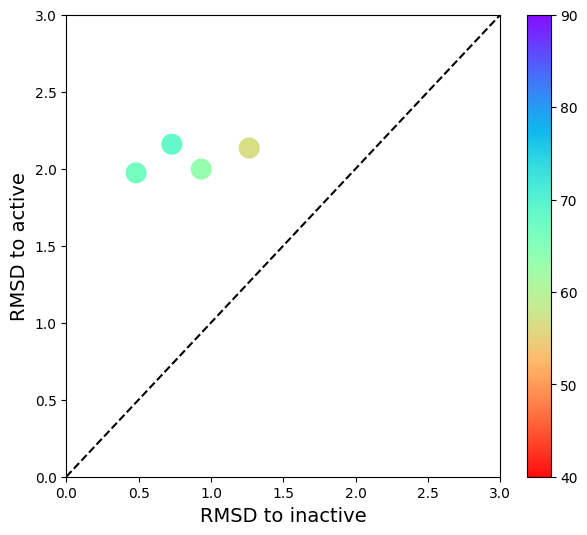

In [13]:
#@markdown **Plot results**
#@markdown Download the reference structures and input their names

import warnings
import MDAnalysis as mda
import glob

warnings.filterwarnings("ignore")
pdbs = []
contacts = []
names = []
plddts = []
plddts_full = []
iptms = []
ipaes = []

fold1_pdb = '8u4p_active.pdb' #@param {type:"string"}
fold2_pdb = '3oe6_inactive.pdb' #@param {type:"string"}

ref_inactive = mda.Universe(f'/content/{fold1_pdb}')
ref_inactive = ref_inactive.select_atoms('protein and name CA and (resid 211-225 or resid 235-250)')
ref_active = mda.Universe(f'/content/{fold2_pdb}')
ref_active = ref_active.select_atoms('protein and name CA and (resid 211-225 or resid 235-250)')

for i in glob.glob(f'/content/{jobname_metamorphic}/lig_msas/pdbs//*.pdb'):

    u = mda.Universe(i)
    u = u.select_atoms("chainID B and name CA and (resid 211-225 or resid 235-250)")
    R_inactive = mda.analysis.rms.RMSD(u, ref_inactive,)
    R_inactive.run()

    R_active = mda.analysis.rms.RMSD(u, ref_active,)
    R_active.run()

    name = i.split('/')[-1].split('_')[1]

    data = open(f'/content/{jobname_metamorphic}/lig_msas/pdbs/EX_{name}_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json')
    #conf_prediction/a2a/a2a_gi/pdbs/EX_000_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json
    #conf_prediction/a2a/a2a_msas/pdbs/EX_000_scores_rank_001_alphafold2_model_1_seed_000.json
    #conf_prediction/a2a/a2a_gi/pdbs/EX_000_predicted_aligned_error_v1.json
    data = json.load(data)
    plddts.append(np.mean(data['plddt']))
    plddts_full.append(data['plddt'])
    #iptms.append(data['iptm'])
    #ipaes.append(np.mean(np.array([np.min(np.array(data['pae'])[chain_a_hotspots[0]:chain_a_hotspots[1],i]) for i in chain_b_hotspots])))
    pdbs.append(np.array([R_inactive.rmsd[0][-1], R_active.rmsd[0][-1]]))
    names.append(i)
    #contacts.append(euclidean_distances(u.atoms.positions,u.atoms.positions).reshape((1,-1))[0])
pdbs = np.array(pdbs).T
contacts.append(euclidean_distances(ref_inactive.atoms.positions,ref_inactive.atoms.positions).reshape((1,-1))[0])
contacts.append(euclidean_distances(ref_active.atoms.positions,ref_active.atoms.positions).reshape((1,-1))[0])

plt.rcParams["figure.figsize"] = (7,6)
data = pd.DataFrame({'rmsd1':pdbs[0],
                     'rmsd2':pdbs[1],
                     'plddts1':plddts,
                     'name':names})
data = data.sort_values(by='plddts1')

plt.scatter(data['rmsd1'],data['rmsd2'], c=data['plddts1'], cmap='rainbow_r', alpha=0.95, s=200, vmin=40, vmax=90)
plt.ylim(0,3)
plt.xlim(0,3)
plt.xlabel('RMSD to inactive', fontsize=14)
plt.ylabel('RMSD to active', fontsize=14)
#plt.axhline(y = 0.8, xmin = 0, xmax = 1.2)
#plt.axvline(x = 0.8, ymin = 0, ymax = 1.2)
plt.colorbar()
plt.plot([0, 3], [0,3], ls="--", c='black')
#plt.savefig('results/image.png', dpi=600)